
## Module 2: Model Training - Itegrating Cross-Validation 

In [1]:
import os
os.chdir("..")
print(os.getcwd())

/Users/matildamwendwa/Desktop/Desktop - Admin’s MacBook Pro/Python_Projects/fed-fraud-detection


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from IPython.display import clear_output
from sklearn.metrics import precision_recall_curve, auc, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold

from src.model_base import FraudDetectionModel, FocalLoss
from scripts.model_training import model_evaluate, get_datasets

## Configuration

In [4]:
CONFIG = {
    "batch_size": 256,
    "epochs": 50,
    "learning_rate": 0.0005,
    "weight_decay": 1e-5,
    "patience": 3,  # For learning rate scheduling
    "early_stop_patience": 5
}

## 2. Model Initialization

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = FraudDetectionModel().to(DEVICE)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=CONFIG["learning_rate"],
    weight_decay=CONFIG["weight_decay"]
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode="max",
    patience=CONFIG["patience"],
)
criterion = FocalLoss()

## 3. Training Loop

In [ ]:
def run_cv_training():
    full_dataset, labels = get_datasets()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"\n🚀 Fold {fold + 1}/5")

        # DataLoaders
        train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=CONFIG["batch_size"], shuffle=True)
        val_loader = DataLoader(Subset(full_dataset, val_idx), batch_size=CONFIG["batch_size"]*2)

        # History
        history = {
            "train_loss": [],
            "val_auc": [],
            "val_f1": []
        }

        for epoch in range(CONFIG["epochs"]):
            model.train()
            epoch_loss = 0

            for xb, yb in train_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                optimizer.zero_grad()
                outputs = model(xb)
                loss = criterion(outputs, yb)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                epoch_loss += loss.item()

            # Validation phase
            val_metrics = model_evaluate(model, val_loader, DEVICE)
            scheduler.step(val_metrics["auc_prc"])

            # Store metrics
            history["train_loss"].append(epoch_loss / len(train_loader))
            history["val_auc"].append(val_metrics["auc_prc"])
            history["val_f1"].append(val_metrics["f1"])

            # Live plot
            clear_output(wait=True)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            ax1.plot(history["train_loss"], label="Training Loss")
            ax1.set_title("Training Loss")
            ax1.set_xlabel("Epoch")
            ax1.legend()
            ax2.plot(history["val_auc"], label="Validation AUPRC")
            ax2.plot(history["val_f1"], label="Validation F1")
            ax2.set_title("Validation Metrics")
            ax2.set_xlabel("Epoch")
            ax2.legend()
            plt.show()

            # Log
            print(f"Epoch {epoch+1}/{CONFIG['epochs']}")
            print(f"Train Loss: {history['train_loss'][-1]:.4f}")
            print(f"Val AUPRC: {history['val_auc'][-1]:.4f}")
            print(f"Val F1: {history['val_f1'][-1]:.4f}")

        # Store best fold metrics
        best_epoch = np.argmax(history["val_auc"])
        fold_results.append({
            "fold": fold + 1,
            "best_val_auc": history["val_auc"][best_epoch],
            "best_val_f1": history["val_f1"][best_epoch]
        })

    # Print summary
    print("\n📊 Cross-Validation Summary:")
    for result in fold_results:
        print(f"Fold {result['fold']}: AUPRC={result['best_val_auc']:.4f}, F1={result['best_val_f1']:.4f}")

    avg_auc = np.mean([r["best_val_auc"] for r in fold_results])
    avg_f1 = np.mean([r["best_val_f1"] for r in fold_results])
    print(f"\n🔍 Avg AUPRC: {avg_auc:.4f} | Avg F1: {avg_f1:.4f}")

    return fold_results

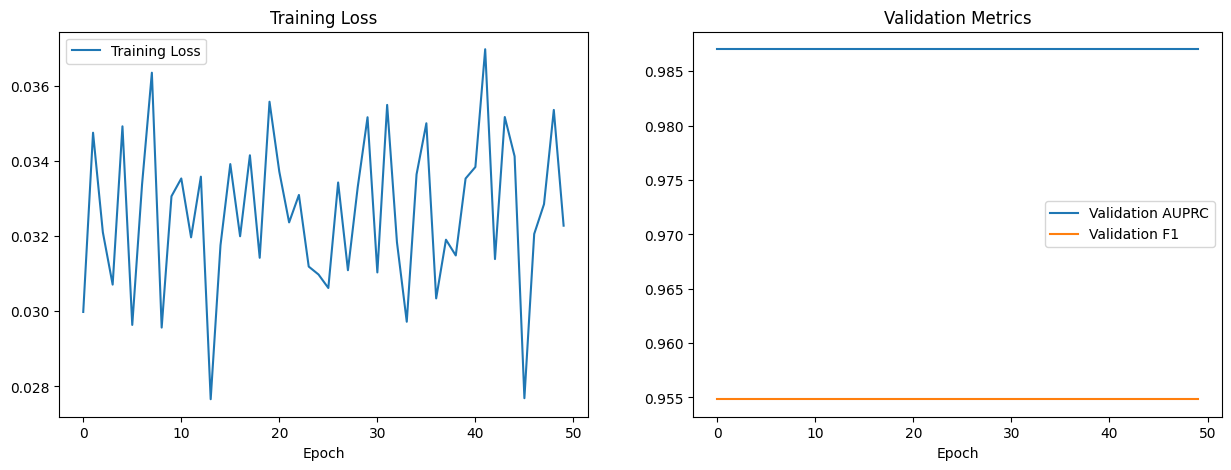

Epoch 50/50
Train Loss: 0.0323
Val AUPRC: 0.9870
Val F1: 0.9548

📊 Cross-Validation Summary:
Fold 1: AUPRC=0.9802, F1=0.9172
Fold 2: AUPRC=0.9948, F1=0.9536
Fold 3: AUPRC=0.9935, F1=0.9615
Fold 4: AUPRC=0.9966, F1=0.9669
Fold 5: AUPRC=0.9870, F1=0.9548

🔍 Avg AUPRC: 0.9904 | Avg F1: 0.9508


In [9]:
results = run_cv_training()

In [24]:
# Check class distribution per fold
def check_fold_distributions(X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for fold, (_, val_idx) in enumerate(skf.split(X, y), 1):
        val_labels = y[val_idx]
        ratio = np.mean(val_labels)
        print(f"Fold {fold} - Positive class ratio: {ratio:.4f} ({np.sum(val_labels)} positives out of {len(val_labels)})")

In [25]:
# Investigate Fold 1 data characteristics
def inspect_fold_1(dataset, labels):
    # Convert TensorDataset to numpy arrays
    X_all = dataset.tensors[0].numpy()
    y_all = dataset.tensors[1].numpy()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)):
        if fold == 0:
            X_fold, y_fold = X_all[train_idx], y_all[train_idx]
            print("Fold 1 stats:")
            print(pd.Series(y_fold).value_counts(normalize=True))
            print("Feature summary (first 3 features):")
            print(pd.DataFrame(X_fold[:, :3]).describe())
            break


In [26]:
full_dataset, labels = get_datasets()
check_fold_distributions(full_dataset, labels)
inspect_fold_1(full_dataset, labels)

Fold 1 - Positive class ratio: 0.5000 (79 positives out of 158)
Fold 2 - Positive class ratio: 0.5000 (79 positives out of 158)
Fold 3 - Positive class ratio: 0.5000 (79 positives out of 158)
Fold 4 - Positive class ratio: 0.4968 (78 positives out of 157)
Fold 5 - Positive class ratio: 0.5032 (79 positives out of 157)
Fold 1 stats:
0    0.5
1    0.5
Name: proportion, dtype: float64
Feature summary (first 3 features):
                0           1           2
count  630.000000  630.000000  630.000000
mean     0.023549   -2.526504    1.923715
std      0.554320    5.783181    3.829518
min     -0.973431  -30.552380   -8.402154
25%     -0.443261   -2.789890   -0.159260
50%     -0.085663   -0.790239    0.987844
75%      0.558970    0.985135    2.921893
max      1.030680    2.194489   22.057730


In [30]:
# Evaluate on held-out test set
def evaluate_on_test(model, device):
    X_test = pd.read_parquet("data/preprocess/X_test.parquet").values
    y_test = pd.read_parquet("data/preprocess/y_test.parquet").squeeze().values
    model.eval()
    with torch.no_grad():
        inputs = torch.FloatTensor(X_test).to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = (probs > 0.5).astype(int)
    print("\nHeld-out Test Classification Report:")
    print(classification_report(y_test, preds))
    return y_test, probs, preds


In [31]:
evaluate_on_test(model, DEVICE)


Held-out Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56864
           1       0.03      0.91      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.93      0.52     56962
weighted avg       1.00      0.95      0.97     56962



(array([0, 0, 0, ..., 0, 0, 0]),
 array([0.16705169, 0.17154978, 0.23164265, ..., 0.11157133, 0.11829491,
        0.32516378], dtype=float32),
 array([0, 0, 0, ..., 0, 0, 0]))